In [1]:
import pandas as pd
from scipy.spatial.distance import cosine
import fasttext
from sklearn.naive_bayes import GaussianNB
import numpy as np

from intent_detector import nb_query_eval

In [2]:
def word_similarity(w0, w1):
    return cosine(ft.get_word_vector(w0), ft.get_word_vector(w1))
    
def sent_similarity(w0, w1):
    return cosine(ft.get_sentence_vector(w0), ft.get_sentence_vector(w1))

In [3]:
with open('intent_detector/nb_query_eval/resources/stopwords.txt') as file:
    lines = file.readlines()
    stopwords = [line.rstrip() for line in lines]

tokenizer = nb_query_eval.Tokenizer(stopwords)

In [4]:
ft = fasttext.load_model('cc.cs.300.bin')

In [45]:
sent_similarity('předčasné splacení půjčky dům', 'splatit hypotéku rychle hned')

0.36361825466156006

# Banking dataset

In [6]:
def words_only(x, tokenizer):
    tks = tokenizer.fit(x)
    return [p[0] for p in tks if p[1] == 'KW']

In [7]:
# train

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
# clf = SVC(probability=True)

df = pd.read_csv('data_text2bank/banking-train-translated.csv')
df['words_list'] = df['text_cz'].apply(words_only, tokenizer=tokenizer)
df_prep = df.explode('words_list')

# ft = fasttext.load_model('cc.cs.300.bin')

df_prep['word_emb'] = df_prep['words_list'].apply(ft.get_word_vector)

X_train = df_prep['word_emb']
y_train = df_prep['kategorie']

clf = GaussianNB()
clf.fit(X_train.tolist(), y_train.tolist())

GaussianNB()

In [8]:
# test

df_test = pd.read_csv('data_text2bank/banking-test-translated.csv')

df_test['words_list'] = df_test['text_cz'].apply(words_only, tokenizer=tokenizer)

y_pred = []
for row in df_test.iterrows():
    y_proba_one = clf.predict_proba(
        [ft.get_word_vector(word) for word in row[1]['words_list']])
    y_pred.append(y_proba_one.mean(axis=0))

y_test = df_test['kategorie'] 

In [9]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y_test_b = lb.fit_transform(y_test)

## ROC

In [10]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test_b, y_pred)

0.8917740195659604

## TOP3

In [11]:
from sklearn.metrics import top_k_accuracy_score

top_k_accuracy_score(y_test, y_pred, k=3, normalize=True, labels=clf.classes_) 

0.45324675324675323

In [14]:
from sklearn.metrics import top_k_accuracy_score

top_k_accuracy_score(y_test, y_pred, k=1, normalize=True, labels=clf.classes_) 

0.29318181818181815

## CLF report

In [12]:
y_pred_labels = [clf.classes_[pred] for pred in np.argmax(y_pred, axis=1)]

In [13]:
from sklearn.metrics import classification_report

# classification_report(y_test)

print(classification_report(y_test, y_pred_labels))

                                                          precision    recall  f1-score   support

                            Vrácení peněz se nezobrazuje       0.78      0.35      0.48        40
                                    aktivovat moji kartu       0.00      0.00      0.00        40
                               apple pay nebo google pay       0.73      0.80      0.76        40
                                  automatické doplňování       0.08      0.90      0.15        40
                                  bezkontaktní nefunguje       0.43      0.30      0.35        40
                                     dobití se nezdařilo       0.00      0.00      0.00        40
                                          dobití vráceno       0.27      0.15      0.19        40
                                         dobíjení kartou       0.00      0.00      0.00        40
                                    dobít nabitím kartou       0.00      0.00      0.00        40
                   

/home/sfabo/.pyenv/versions/3.9.2/envs/dip/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sfabo/.pyenv/versions/3.9.2/envs/dip/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sfabo/.pyenv/versions/3.9.2/envs/dip/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [54]:
cls = 'dobití se nezdařilo'
word = 'Můžete mi říct, proč moje dobití nefungovalo?'

import itertools

most_similars = []
for cls in clf.classes_:
    # print(cls, end='\n\n')
    simils = []
    for c, w in itertools.product(words_only(cls, tokenizer), words_only(word, tokenizer)):
        # print(perm)
        # print((c, w, word_similarity(c, w)))
        simils.append(word_similarity(c, w))
    most_similars.append(np.min(simils))

sl = list(zip(clf.classes_, most_similars)).sort(key=lambda y: y[1])
sl

# Sentence Vectorizer

In [36]:
# train

df = pd.read_csv('data_text2bank/banking-train-translated.csv')
df['words_list'] = df['text_cz'].apply(words_only, tokenizer=tokenizer)

X_train = df['words_list'].apply(lambda x: ft.get_sentence_vector(' '.join(x)))
y_train = df['kategorie']

clf = GaussianNB()
clf.fit(X_train.tolist(), y_train.tolist())

GaussianNB()

In [42]:
df_test = pd.read_csv('data_text2bank/banking-test-translated.csv')

df_test['words_list'] = df_test['text_cz'].apply(words_only, tokenizer=tokenizer)

X_test = df_test['words_list'].apply(lambda x: ft.get_sentence_vector(' '.join(x)))
y_test = df_test['kategorie']

y_pred = clf.predict_proba(X_test.tolist())

In [43]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y_test_b = lb.fit_transform(y_test)

## ROC

In [44]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test_b, y_pred)

0.9854469625768969

## Explore?

In [80]:
col_text_name, col_class_name = 'text', 'category'
# col_text_name, col_class_name = 'text_cz', 'kategorie'
use_stopwords = True
df_train = pd.read_csv('data_text2bank/t2b-train.csv')
df_test = pd.read_csv('data_text2bank/t2b-test.csv')
# df_train = pd.read_csv('data_text2bank/banking-train-translated.csv')
# df_test = pd.read_csv('data_text2bank/banking-test-translated.csv')

# reduce classes to 5 most common

df_train = df_train[df_train[col_class_name].isin(['jednorázová platba tuzemská', 'výpisy', 'chci půjčit/kolik mi půjčíte', 'sjednat schůzku na pobočce'])]

with open(str('intent_detector/nb_query_eval/resources/stopwords.txt')) as f:
    sw = [line.strip() for line in f.readlines()]
tkzr = nb_query_eval.Tokenizer(sw if use_stopwords else [])

df_train['words_list'] = df_train[col_text_name].apply(words_only, tokenizer=tkzr)

X_train = df_train['words_list'].apply(lambda x: ft.get_sentence_vector(' '.join(x)))
y_train = df_train[col_class_name]

df_test['words_list'] = df_test[col_text_name].apply(words_only, tokenizer=tkzr)
X_test = df_test['words_list'].apply(lambda x: ft.get_sentence_vector(' '.join(x)))
y_test = df_test[col_class_name]


In [35]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

In [85]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10), 'figure.dpi': 400})

In [8]:
reducer = umap.UMAP()

In [81]:
embedding = reducer.fit_transform(X_train.tolist())
embedding.shape

(159, 2)

In [82]:
data = pd.DataFrame({'cat': y_train, 'emb_0': embedding[:, 0], 'emb_1': embedding[:, 1]})

<AxesSubplot:xlabel='emb_0', ylabel='emb_1'>

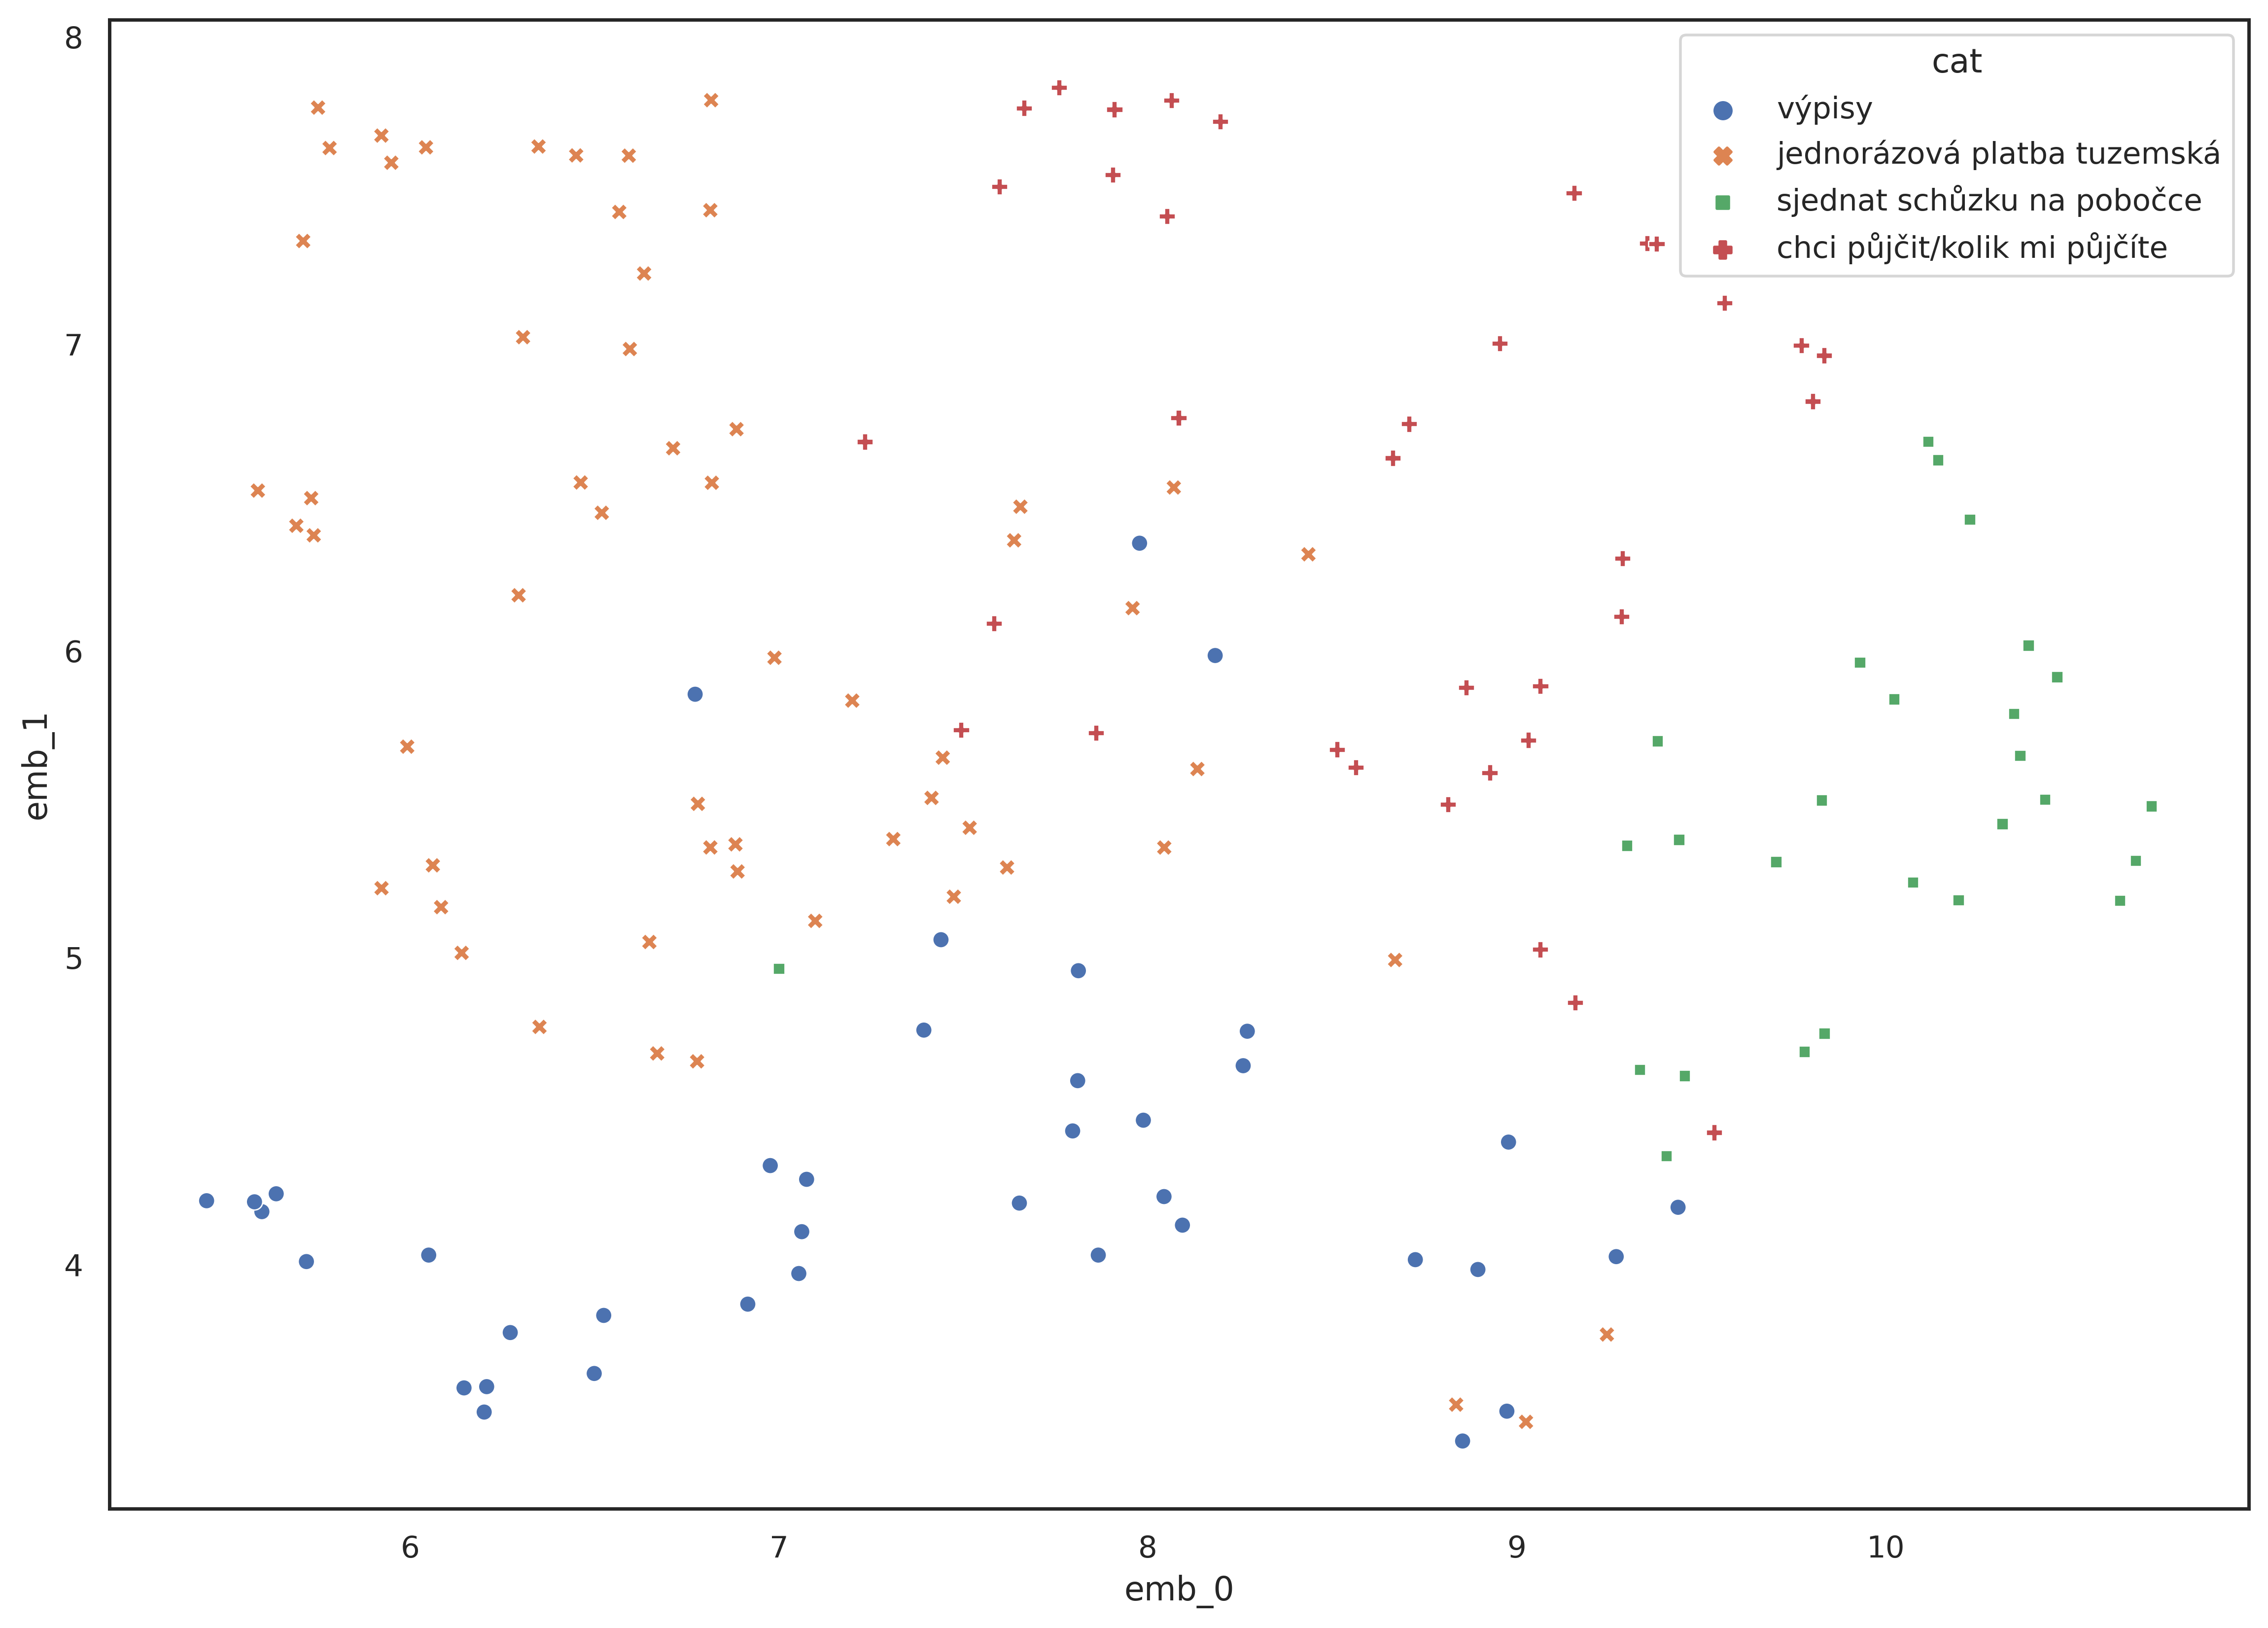

In [87]:
sns.scatterplot(
    x='emb_0',
    y='emb_1',
    data=data,
    hue='cat',
    style='cat'
    )
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of the BANKING dataset', fontsize=24)

# FT classifier

In [7]:
df = pd.read_csv('data_text2bank/cs_banking77/banking-train-translated.csv')
df['words_list'] = df['text_cz'].apply(words_only, tokenizer=tokenizer)

In [11]:
model = fasttext.train_supervised(input="cooking.train")

Read 0M words
Number of words:  14543
Number of labels: 735
Progress: 100.0% words/sec/thread:   42436 lr:  0.000000 avg.loss: 10.231929 ETA:   0h 0m 0s


In [12]:
model.save_model("model_cooking.bin")

In [13]:
model.predict("Which baking dish is best to bake a banana bread ?")

(('__label__baking',), array([0.06991774]))

# Class similarity

In [ ]:
def class_simil(ft, intent, classes: list):
    for cls in classes:
        